In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import itertools
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
import seaborn as sns

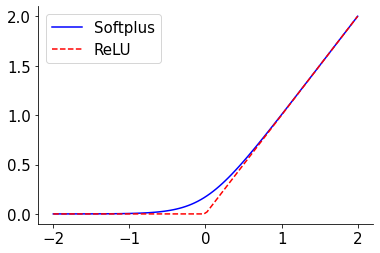

In [2]:
a = torch.linspace(-2,2,100)
plt.plot(a,F.softplus(a,beta=4),color='blue',label='Softplus')
# plt.plot(a,F.elu(a-1)+1,color='red',label='ELU')
plt.plot(a,F.relu(a),'--',color='red',label='ReLU')
plt.legend()
sns.despine()
plt.show()

In [3]:
def n_choose_k(n,k):
    num_permutations = np.math.factorial(n) / (np.math.factorial(k)*np.math.factorial(n-k))
    return int(num_permutations)

def n_hot_patterns(n,length):
    all_permutations = torch.tensor(list(itertools.product([0., 1.], repeat=length)))
    pattern_hotness = torch.sum(all_permutations,axis=1)
    idx = torch.where(pattern_hotness == n)[0]
    n_hot_patterns = all_permutations[idx]
    return n_hot_patterns

print(n_choose_k(7,2))
n_hot_patterns(n=2,length=4)

21


tensor([[0., 0., 1., 1.],
        [0., 1., 0., 1.],
        [0., 1., 1., 0.],
        [1., 0., 0., 1.],
        [1., 0., 1., 0.],
        [1., 1., 0., 0.]])

In [4]:
class autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.in_size = input_size
        self.hidden_size = hidden_size 
        self.output_size = output_size 
        
        self.in2hidden = nn.Linear(self.in_size, self.hidden_size, bias=True)
        self.hidden2out = nn.Linear(self.hidden_size, self.output_size, bias=True)
    
    def forward(self, input_pattern, act_sharpness=4):
        hidden = self.in2hidden(input_pattern)
        hidden = F.softplus(hidden, beta=act_sharpness)
#         hidden = F.relu(hidden)

        output = self.hidden2out(hidden)
        output = F.softplus(output, beta=act_sharpness)
#         output = F.relu(output)

        return output, hidden
    
        
    def train(self, num_epochs, all_patterns, learning_rate):
        
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.MSELoss()
        num_patterns = all_patterns.shape[0]
        
        hidden_history = torch.zeros(self.hidden_size, num_patterns, num_epochs)
        output_history = torch.zeros(self.output_size, num_patterns, num_epochs)
        loss_history = []
        accuracy_history = []
        
        for epoch in tqdm(range(num_epochs)):
            for pattern_idx in torch.randperm(num_patterns):
                input_pattern = all_patterns[pattern_idx]
                target  = torch.eye(self.output_size)[pattern_idx]

                output, hidden = self.forward(input_pattern)
                
                hidden_history[:,pattern_idx,epoch] = hidden.detach()
                output_history[:,pattern_idx,epoch] = output.detach()

                loss = criterion(output, target)                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Compute final loss and accuracy at the end of this epoch
            with torch.no_grad():
                epoch_loss = 0
                accuracy = 0
                for i, pattern in enumerate(all_patterns):
                    output, _ = self.forward(pattern)
                    target = torch.eye(self.output_size)[i]
                    
                    epoch_loss += criterion(output, target)
                    accuracy += (torch.argmax(output)==i).float()*100

            loss_history.append(epoch_loss/num_patterns) 
            accuracy_history.append(accuracy/num_patterns)
            
#             output_argmax = torch.argmax(output_history[:,:,epoch], dim=1)
#             target_argmax = torch.argmax(torch.eye(self.output_size), dim=1)
#             accuracy = torch.mean((output_argmax == target_argmax).float()) * 100
#             accuracy_history.append(accuracy)
                            
        return output_history, hidden_history, torch.tensor(loss_history), torch.tensor(accuracy_history)

In [5]:
seed = 123
torch.manual_seed(seed)

# Initialize RNN
input_size = 21
hidden_size = 7
output_size = 21

model = autoencoder(input_size, hidden_size, output_size)

# Train network
num_epochs = 400
lr = 0.02
# lr = 0.002
# all_patterns = n_hot_patterns(n=1,length=input_size)
all_patterns = torch.eye(21)
output_history, hidden_history, loss_history, accuracy_history = model.train(num_epochs, all_patterns, lr)

100%|██████████| 400/400 [00:03<00:00, 132.69it/s]


Epochs to 100.0% accuracy: 11
stable accuracy + 50 epochs = 72
Stable epoch: 73


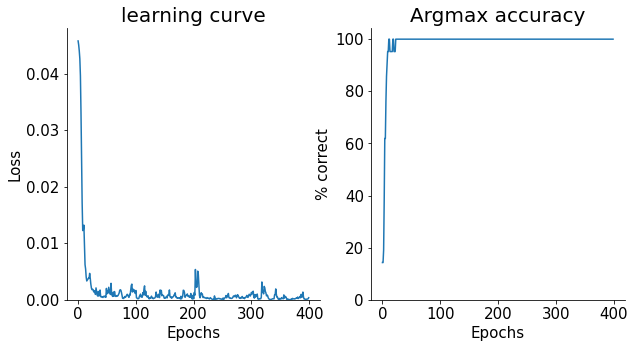

In [6]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(loss_history)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim(bottom=0)
ax[0].set_title('learning curve',fontsize=20)

ax[1].plot(accuracy_history)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('% correct')
ax[1].set_ylim(bottom=0)

ax[1].set_title('Argmax accuracy',fontsize=20)

m = torch.max(accuracy_history)
print(f"Epochs to {torch.round(m)}% accuracy: {torch.where(accuracy_history>=m)[0][0]}")

print(f"stable accuracy + 50 epochs = {torch.where(accuracy_history<100)[0][-1]+50}")
for i in range(num_epochs):
    if torch.all(accuracy_history[i:i+50] == 100):
        print('Stable epoch:',i+50)
        epoch = i+50
        break
    else:
        epoch = -1
        
sns.despine()
plt.show()

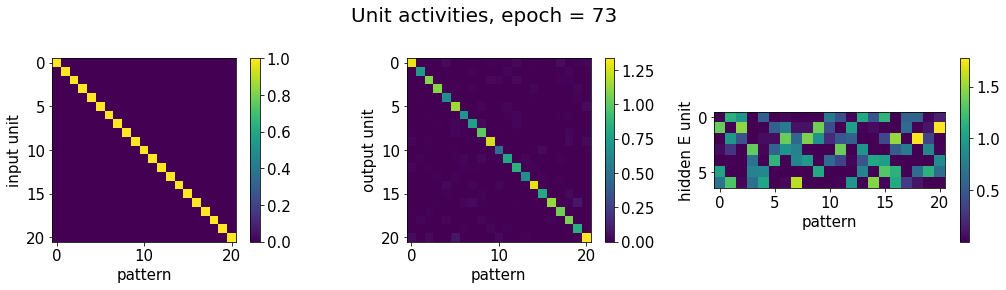

mean population sparsity (hidden) = 0.6508183479309082


In [7]:
def plot_activity(epoch,dynamic=False):
    if dynamic==True:
        epoch = epoch*10
    
    fig, ax = plt.subplots(1,3,figsize=(15,4))
    axis = 0
    im = ax[axis].imshow(all_patterns.T,aspect='equal')
    plt.colorbar(im, ax=ax[axis])
    ax[axis].set_xlabel('pattern')
    ax[axis].set_ylabel('input unit')

    axis = 1
    im = ax[axis].imshow(output_history[:,:,epoch],aspect='equal')
    plt.colorbar(im, ax=ax[axis])
    ax[axis].set_xlabel('pattern')
    ax[axis].set_ylabel('output unit')

    axis = 2
    im = ax[axis].imshow(hidden_history[:,:,epoch],aspect='equal')
    plt.colorbar(im, ax=ax[axis])
    ax[axis].set_xlabel('pattern')
    ax[axis].set_ylabel('hidden E unit')

    plt.suptitle(f"Unit activities, epoch = {epoch}",fontsize=20)
    plt.tight_layout()
    plt.show()
    
plot_activity(epoch)


# Sparsity metric from (Vinje & Gallant 2000): https://www.science.org/doi/10.1126/science.287.5456.1273
sparsity = torch.empty(input_size)
for i,pop_activity in enumerate(hidden_history[:,:,epoch].T):
    n = pop_activity.shape[0]
    activity_fraction = (torch.sum(pop_activity)/n)**2 / torch.sum(pop_activity**2/n)
    sparsity[i] = (1 - activity_fraction)/(1 - 1/n)
    
print(f"mean population sparsity (hidden) = {torch.mean(sparsity)}")

In [8]:
import ipywidgets as widgets

widgets.interact(plot_activity, epoch=(0,int(num_epochs/10-1),1),dynamic=True);
# widgets.interact(plot_activity, epoch=widgets.Play(min=1,max=80));

interactive(children=(IntSlider(value=19, description='epoch', max=39), Checkbox(value=True, description='dyna…

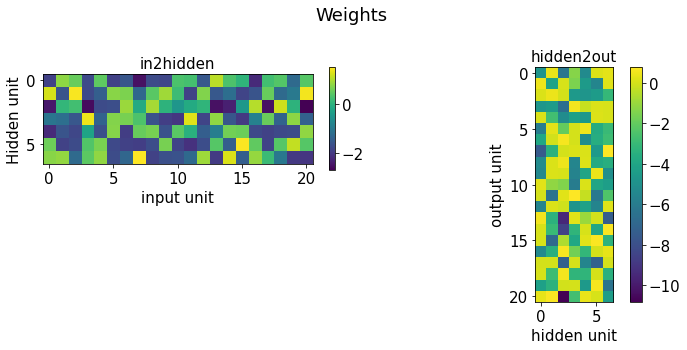

In [9]:
import matplotlib.gridspec as gs

fig = plt.figure(figsize=(10, 5))
axes = gs.GridSpec(nrows=2, ncols=2)
#                    left=0.05,right=0.98,
#                    top = 0.95, bottom = 0.2,
#                    wspace=0.8, hspace=1.2)


# Hidden weights
ax = fig.add_subplot(axes[0,0])
im = ax.imshow(model.in2hidden.weight.data,aspect='equal')
plt.colorbar(im, ax=ax)
ax.set_xlabel('input unit')
ax.set_ylabel('Hidden unit')
ax.set_title('in2hidden',fontsize=15)

# Output weights
ax = fig.add_subplot(axes[0:2,1])
im = ax.imshow(model.hidden2out.weight.data,aspect='equal')
plt.colorbar(im, ax=ax)
ax.set_xlabel('hidden unit')
ax.set_ylabel('output unit')
ax.set_title('hidden2out',fontsize=15)

plt.suptitle("Weights")

plt.tight_layout()
plt.show()

In [10]:
import h5py

description = "FF_network_1hidden"
export_file_path = "data.hdf5"

activity_dict = {0:{'E':all_patterns.T},
                 1:{'E':hidden_history[:,:,epoch]},
                 2:{'E':output_history[:,:,epoch]}}

weight_dict   = {0: {},
                 1: {'E_FF':model.in2hidden.weight.data},
                 2: {'E_FF':model.hidden2out.weight.data}}

metrics_dict = {'loss':loss_history,
                'accuracy':accuracy_history}


with h5py.File(export_file_path, 'a') as f:
    if description in f:
        del f[description]
        
    model_group = f.create_group(description)
    model_group.attrs['seed'] = seed
    model_group.attrs['lr'] = lr

    activity_group = model_group.create_group('activity_dict')
    weight_group = model_group.create_group('weight_dict')
    metrics_group = model_group.create_group('metrics_dict')

    for layer in [0,1,2]:
        layer_activity = activity_group.create_group(str(layer))
        layer_weight = weight_group.create_group(str(layer))
        
        for pop in activity_dict[layer]:
            layer_activity.create_dataset(pop, data=activity_dict[layer][pop])
            
        for projection in weight_dict[layer]:
            layer_weight.create_dataset(projection, data=weight_dict[layer][projection])
            
    for metric in metrics_dict:
        metrics_group.create_dataset(metric, data=metrics_dict[metric])